# Análisis de textos

In [2]:
%pip install num2words

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import num2words
import re, unicodedata, inflect
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
RECALL = "Recall:"
PRECISION = "Precision:"
F1 = "F1:"

In [6]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [7]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\German\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\German\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [9]:
ods_df = pd.read_csv("../data/cat_6716.csv")

In [10]:
ods_df.shape

(3000, 2)

In [11]:
ods_df.sample(5)

,Textos_espanol,sdg
1588,"La tecnología de la información y las comunicaciones junto con las redes inteligentes y los sistemas inteligentes forman la columna vertebral del nuevo sistema energético. Además, las plantas de combustibles fósiles se ven presionadas por el costo creciente de sus emisiones de C02. Sin embargo, las regiones con carbón de alta calidad y bajo costo utilizan Captura y Almacenamiento de Carbono (CCS, comercialmente competitivo y disponible a partir de 2030).",7
2246,"Ha habido un movimiento gradual hacia el reconocimiento de problemas de seguridad más diversos como amenazas de seguridad para actores más diversos en fronteras más amplias. Si bien la multidimensionalidad de la seguridad ahora se reconoce ampliamente en el discurso de seguridad, sus impactos y desafíos para el derecho internacional aún no se han examinado completamente. En particular, la concepción ampliada de la seguridad ha planteado desafíos al sistema de seguridad colectiva de la ONU. Este artículo considera los desafíos que se le plantean a la seguridad colectiva, con respecto a cuatro objetos diferentes de seguridad: seguridad nacional, seguridad internacional, seguridad humana y seguridad de régimen. Discute los límites de la seguridad colectiva para responder de manera efectiva a la concepción ampliada de la seguridad dentro del marco existente del derecho internacional, y revisa enfoques de seguridad alternativos, evaluando su potencial para complementar la seguridad colectiva al tratar con diversos objetos y amenazas de seguridad.",16
140,"El objetivo del Gobierno vuelve a ser cobrar gradualmente a la industria el coste del suministro de agua para 2050. El objetivo final es tratar casi el 100% de las aguas residuales hasta un nivel que permita su uso sin restricciones en el riego (es decir, sin riesgo de sobrenutriciÃ³n del suelo y las fuentes de agua). En 2009, el 92% de los efluentes cumplían las normas nacionales.20 A partir de 2010, las nuevas normas exigen que la calidad de los efluentes cumpla 36 parámetros, incluidas las concentraciones de cloruro.",6
2547,"El enfoque del desarrollo desigual y combinado (U&CD) en Relaciones Internacionales (RI) pretende ofrecer una solución a la cuestión de “lo internacional” con una teoría única y coherente capaz de unir factores sociológicos y geopolíticos en la explicación del cambio social. . Por lo tanto, el enfoque pretende proporcionar lo que los teóricos de las relaciones internacionales han estado buscando durante mucho tiempo: una teoría social de lo internacional. Si bien reconoce la importancia de este programa de investigación en el campo de la erudición de las relaciones internacionales, este artículo argumenta que el enfoque U&CD da por sentado lo que debe teorizarse y no proporciona la solución teórica al problema de la “analogía doméstica” que tan poderosamente identifica. .",16
1778,"Además, se espera que la propiedad de automóviles personales aumente rápidamente en muchos países en las próximas décadas. A medida que las tasas de propiedad en las economías emergentes y los países en desarrollo comienzan a acercarse a los niveles de los países de la OCDE, un escenario de negocios como de costumbre los vería enfrentar aumentos significativos en los costos de importación de combustible y los impactos ambientales. Las soluciones clave incluyen transporte público (como trenes ligeros y autobuses de tránsito rápido) y transporte no motorizado (especialmente en regiones que es poco probable que experimenten altos niveles de propiedad de automóviles), mejora de la economía de combustible de los vehículos, adopción de vehículos eléctricos e híbridos enchufables. (EV/PFIEV) y un mayor uso de biocombustibles.",7


In [12]:
ods_df["sdg"].value_counts(dropna=False, normalize=True)

6     0.333333
7     0.333333
16    0.333333
Name: sdg, dtype: float64

In [13]:
textos = ods_df.copy()
textos['Conteo'] = [len(x) for x in textos['Textos_espanol']]
textos['Moda'] = [pd.Series(x).value_counts().index[0] for x in textos['Textos_espanol']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
ods_df["Textos_espanol"] = ods_df["Textos_espanol"].astype(str)

## Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Limpieza de los datos.
* Tokenización.
* Normalización.

<span style="color:red">!!! Antes de ver la solución, revisa alternativas para realizar las tres etapas previas.</span>

Para mayor información, pueden consultar el [siguiente artículo](https://medium.com/datos-y-ciencia/preprocesamiento-de-datos-de-texto-un-tutorial-en-python-5db5620f1767
).

### Limpieza de los datos

In [15]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = num2words.num2words(int(word), lang='es')
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### Tokenización

In [16]:
ods_df["Textos_espanol"] = ods_df["Textos_espanol"].apply(word_tokenize).apply(preprocessing).apply(" ".join)
ods_df.sample(5)

,Textos_espanol,sdg
694,particular inversiones ajustar suministro agua largo plazo ejemplo inversiones extraccion agua asi propuesta opciones alternativas suministro agua hacer frente escasez agua corto plazo fundamentales proporcionar acceso fiable agua dar idea efecto potencial gestion demanda agua informe preparado comision europea dworak et tecnologias ahorro agua solo faciles introducir implementar sino tambien periodos recuperacion cortos mejora aun mas posibilidades captacion,6
2227,choque libertad religiosa libertad expresion creado turbulencia social discordia politica marginacion minorias religiosas visto factor seguridad autor explora posibilidad marco reconcilie libertad religion libertad expresion dentro contexto frances singular acontecimientos recientes muestran problema sigue resolverse tribunales frecuentemente llevados argumentan creencias danadas buscan reparacion defensores libertad expresion veces hostil estan contraatacando autor discutira metodos utilizados jueces franceses determinar ofensa sentimiento religioso veces manera enganosa arbitraria tan ampliamente definida violaciones creencias simbolos ritos religiosos buscara puntos comun normas generalmente aceptadas libertad expresion puede existir marco orden publico respete ciudadanos,16
1835,cuanto gas natural escenarios referencia mapa blue muestran unas necesidades infraestructuras gas natural bastante similares uso maximo gas dos mil cincuenta ciento ochenta bcm total cien bcm generacion electricidad treinta bcm procederian yacimientos existentes cincuenta bcm nuevos yacimientos cien bcm importaciones gnl supondria multiplicar casi diez importaciones gnl dos mil ocho dos mil cincuenta construir seis nuevas instalaciones regasificacion gnl grandes diez mtano,7
229,pone relieve importancia informar hogares implicaciones medioambientales consumo excesivo derrochador agua caso normas medioambientales encuestados explicaciones importantes inversion equipos ahorro agua mas influye inversion propiedad vivienda cobro agua volumen tambian presta atencia3n papel etiquetado ecola3gico caso,6
2424,analizando estatus legal tratados derechos humanos ordenamiento juridico brasileno vista cambios introducidos reforma constitucion n 4504 conocida reforma poder judicial dicha reforma trajo posibilidad tratados derechos humanos asimilados reformas constitucionales rango juridico constitucional obstante guardo silencio respecto aprobado tratado promulgacion embargo corte suprema dio rango supralegal tratado debe examinarse medida cambio constitucional trajo consigo mayor proteccion derechos humanos examina cerca convencion derechos personas discapacidad adoptada forma inciso tres articulo cinco constitucion federal mil novecientos ochenta y ocho,16


### Normalización

In [17]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = nltk.stem.SnowballStemmer('spanish')
    stems = [stemmer.stem(word) for word in words]
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    #Lemmatize for spanish
    stemmer = nltk.stem.SnowballStemmer('spanish')
    lemmas = [stemmer.stem(word) for word in words]
    return lemmas
def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

ods_df["Textos_espanol"] = ods_df["Textos_espanol"].apply(word_tokenize).apply(stem_and_lemmatize).apply(" ".join)
ods_df.sample(5)

,Textos_espanol,sdg
1847,si numer limit unidad gener competidor suficient atend pod merc pued ser problem hech experient pjm mil novecient novent y siet introduj nuev merc capac solucion vari problem demuestr afin merc capac proces dificil larg bas experient merc capac existent exist preocup central electr activ merc capac suficient flexibl si numer limit unidad gener competidor suficient atend pod merc pued ser problem hech experient pjm mil novecient novent y siet introduj nuev merc capac solucion vari problem demuestr afin merc capac proces dificil larg bas experient merc capac existent exist preocup central electr activ merc capac suficient flexibl,7
1982,apoy dich tecnologi pas demostr ser rentabl exit gener asi alto rendimient social inversion fri dos mil tres necesari pon mas enfasis nivel mundial mejor eficient energet uso final complement cambi comport limit impuest uso energi tierr agu material dich program promoveri cooper pais comun individu logr menor uso energi primari menor emision gas efect invernader apoy dich tecnologi pas demostr ser rentabl exit gener asi alto rendimient social inversion fri dos mil tres necesari pon mas enfasis nivel mundial mejor eficient energet uso final complement cambi comport limit impuest uso energi tierr agu material dich program promoveri cooper pais comun individu logr menor uso energi primari menor emision gas efect invernader,7
871,embarg condicion podri ser suficient cambi practic rieg agricultor especial arroz trig cual aun utiliz sistem rieg gote singh dos mil quinc entonc agricultor instal sol dos cer bomb solar subsidi menud suficient sustancial motiv inversion roy dos mil quinc embarg gobi estatal central continu program apoy cost panel solar cayend sugier mayor desarroll bomb solar amenaz aument agot acuifer critic embarg condicion podri ser suficient cambi practic rieg agricultor especial arroz trig cual aun utiliz sistem rieg gote singh dos mil quinc entonc agricultor instal sol dos cer bomb solar subsidi menud suficient sustancial motiv inversion roy dos mil quinc embarg gobi estatal central continu program apoy cost panel solar cayend sugier mayor desarroll bomb solar amenaz aument agot acuifer critic,6
2587,objet articul verific si histor sentenci tribunal suprem italian sesion plenari num 5001999 contribu efect disminu incent merc soborn itali ello remit model teoric acemoglu verdi dos mil analisis empir bas estudi cas realiz sicili provinci catani utiliz conjunt dat unic principal result document pag burocrat mediant salari eficient podri ser util reduc corrupcion extension regl respons emple administr public funcionari public pued reduc fenomen intercambi soborn final especif perfect derech propied util reduc corrupcion objet articul verific si histor sentenci tribunal suprem italian sesion plenari num 5001999 contribu efect disminu incent merc soborn itali ello remit model teoric acemoglu verdi dos mil analisis empir bas estudi cas realiz sicili provinci catani utiliz conjunt dat unic principal result document pag burocrat mediant salari eficient podri ser util reduc corrupcion extension regl respons emple administr public funcionari public pued reduc fenomen intercambi soborn final especif perfect derech propied util reduc corrupcion,16
720,calif riesg mas altas riesg in situ desarroll respect utiliz produc calif inicial establec objet segur hidric pued gui vari caracterist econom part sigu ocde dos mil ocho embarg consecucion objet tambi pued conllev import cost econom calif riesg mas altas riesg in situ desarroll respect utiliz produc calif inicial establec objet segur hidric pued gui vari caracterist econom part sigu ocde dos mil ocho embarg consecucion objet tambi pued conllev import cost econom,6


# Entrenamiento

In [18]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(ods_df[["Textos_espanol"]], ods_df["sdg"], test_size=0.3, stratify=ods_df["sdg"], random_state=1)

In [19]:
X_train.shape, X_test.shape

((2100, 1), (900, 1))

In [20]:
pd.Series(y_train).value_counts(normalize=True)

7     0.333333
6     0.333333
16    0.333333
Name: sdg, dtype: float64

In [21]:
pd.Series(y_test).value_counts(normalize=True)

6     0.333333
7     0.333333
16    0.333333
Name: sdg, dtype: float64

## Text vectorization

In [22]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [23]:
X_bow = bow.fit_transform(X_train["Textos_espanol"])

In [24]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 9820


In [25]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [26]:
X_tfidf = tfidf.fit_transform(X_train["Textos_espanol"])

In [27]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 9820


## Training a model with BoW

In [28]:
bow_model = RandomForestClassifier(random_state=2)

In [29]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<AxesSubplot: >

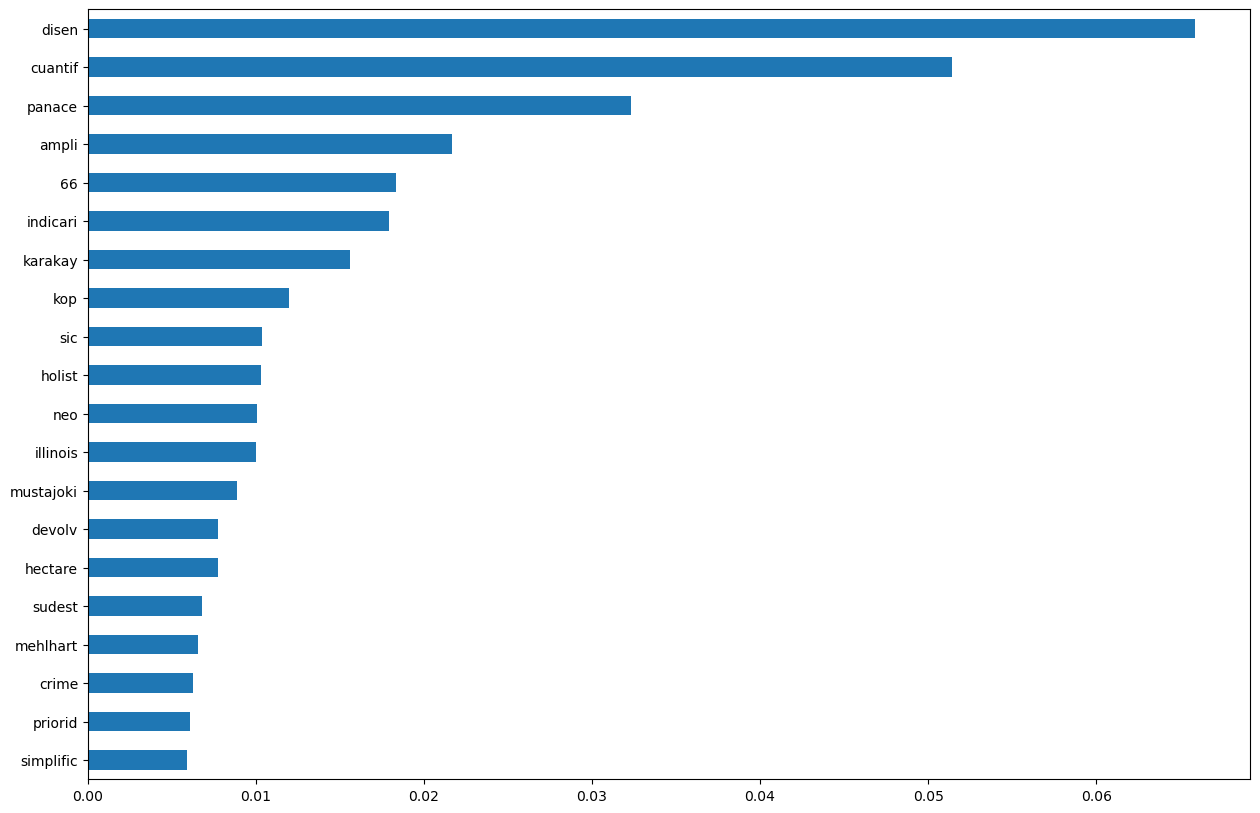

In [30]:
# Feature importance in tree models is an indicator on how relevant is a feature for taking the decision by the model
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [31]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 73.4


In [32]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Textos_espanol"]))

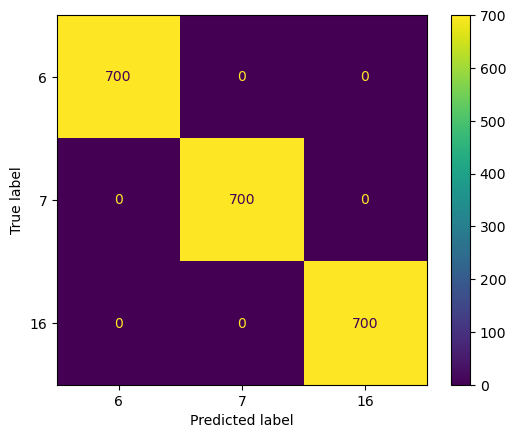

In [33]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

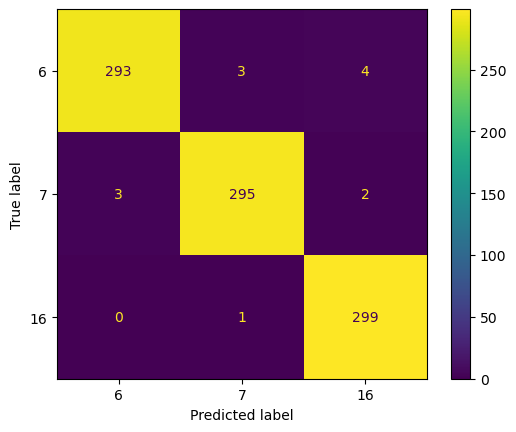

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [35]:
print(PRECISION, precision_score(y_train, y_train_bow_predict, average="weighted"))
print(RECALL, recall_score(y_train, y_train_bow_predict, average="weighted"))
print(F1, f1_score(y_train, y_train_bow_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [36]:
print(PRECISION, precision_score(y_test, y_test_bow_predict, average="weighted"))
print(RECALL, recall_score(y_test, y_test_bow_predict, average="weighted"))
print(F1, f1_score(y_test, y_test_bow_predict, average="weighted"))

Precision: 0.9856049357653064
Recall: 0.9855555555555555
F1: 0.9855420622799852


## Training a model with TF-IDF

In [37]:
tfidf_model = RandomForestClassifier(random_state=3)

In [38]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<AxesSubplot: >

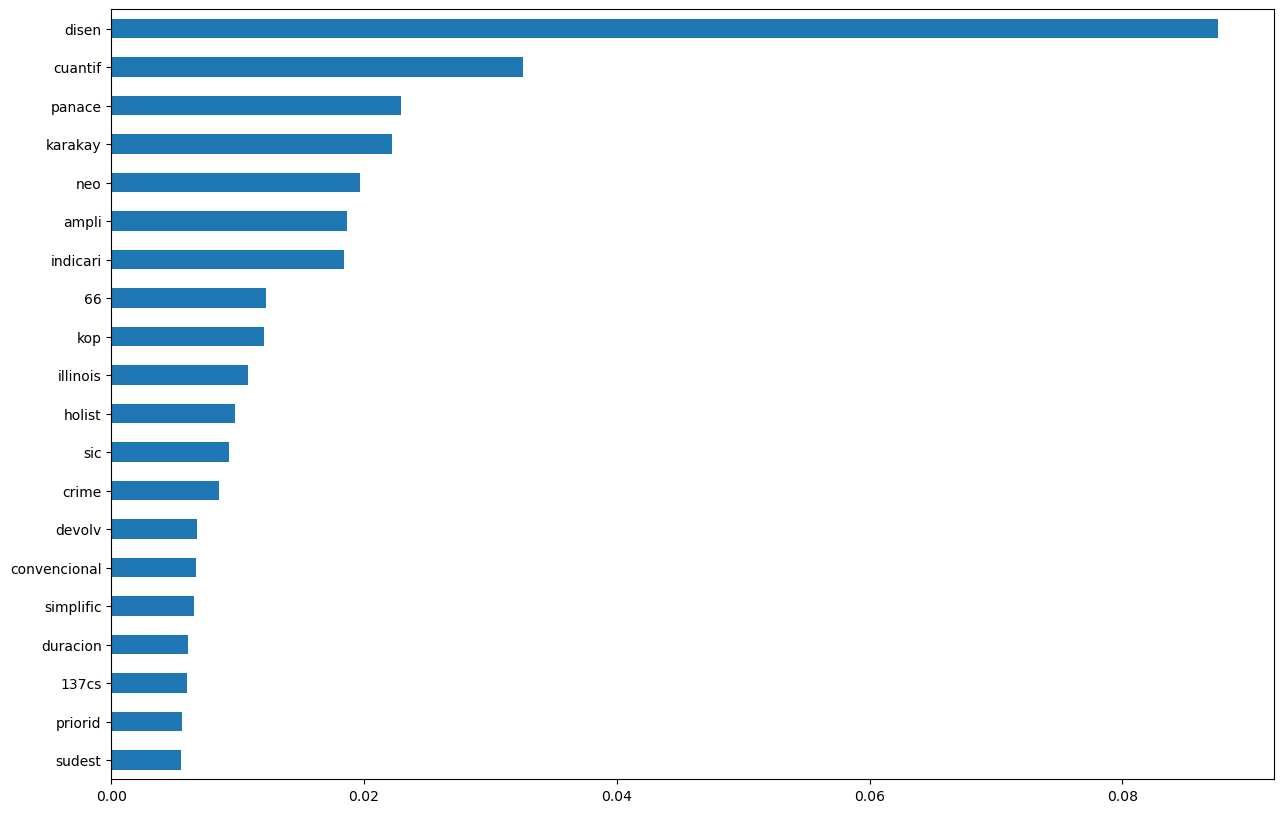

In [39]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [40]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 66.71


In [41]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["Textos_espanol"]))

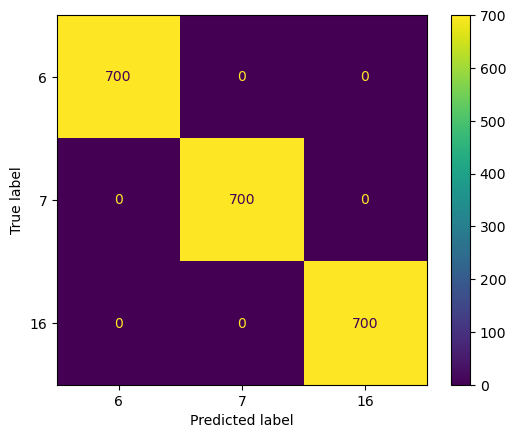

In [42]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

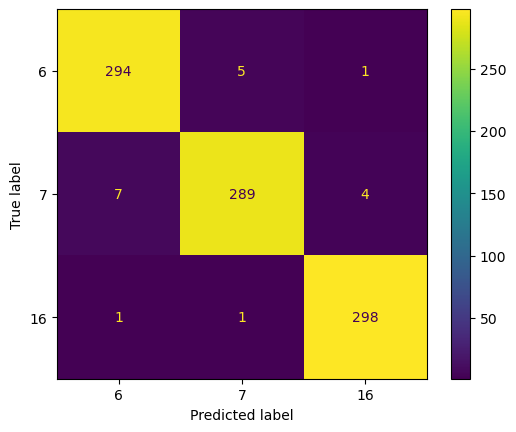

In [43]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [44]:
print(PRECISION, precision_score(y_train, y_train_tfidf_predict, average="weighted"))
print(RECALL, recall_score(y_train, y_train_tfidf_predict, average="weighted"))
print(F1, f1_score(y_train, y_train_tfidf_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [45]:
print(PRECISION, precision_score(y_test, y_test_tfidf_predict, average="weighted"))  
print(RECALL, recall_score(y_test, y_test_tfidf_predict, average="weighted"))
print(F1, f1_score(y_test, y_test_tfidf_predict, average="weighted"))

Precision: 0.9788897668529901
Recall: 0.9788888888888889
F1: 0.9788547113087204


### Model selection

In [46]:
pipeline = Pipeline(steps = [
    ("vectorizer", CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", RandomForestClassifier(random_state=4))
])

In [47]:
param_grid = {
    "vectorizer": [CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words), TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words)],
    "vectorizer__lowercase": [True, False],
    "classifier__n_estimators": [50, 100],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [25, 50, 75, 100]
}

In [48]:
search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring=["precision", "recall", "f1"], refit="f1", cv=3, return_train_score=True, verbose=1, random_state=5)

In [49]:
search.fit(X_train["Textos_espanol"], y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vectorizer',
                                              CountVectorizer(stop_words=['de',
                                                                          'la',
                                                                          'que',
                                                                          'el',
                                                                          'en',
                                                                          'y',
                                                                          'a',
                                                                          'los',
                                                                          'del',
                                                                          'se',
                                                                          'las',
                                                                          'por',
                                                                          'un',
                                                                          'para',
                                                                          'con',
                                                                          'no',
                                                                          'una',
                                                                          'su',
                                                                          'al',
                                                                          'lo',
                                                                          'como',
                                                                          'más',
                                                                          'pero',
                                                                          'sus',
                                                                          'le',
                                                                          'ya',
                                                                          'o',
                                                                          'este',
                                                                          'sí',
                                                                          'porque', ...],
                                                              tokenizer=<function word_tokenize at 0x0000025D0A31F2E0>)),
                                             ('classifier',
                                              RandomForestCla...
                                                                                   'que',
                                                                                   'el',
                                                                                   'en',
                                                                                   'y',
                                                                                   'a',
                                                                                   'los',
                                                                                   'del',
                                                                                   'se',
                                                                                   'las',
                                                                                   'por',
                                                                                   'un',
                                                                                   'para',
                                                                                   'con',
                                                                                 

In [50]:
search.best_params_

{'vectorizer__lowercase': False,
 'vectorizer': CountVectorizer(lowercase=False,
                 stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                             'del', 'se', 'las', 'por', 'un', 'para', 'con',
                             'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                             'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                             'porque', ...],
                 tokenizer=<function word_tokenize at 0x0000025D0A31F2E0>),
 'classifier__n_estimators': 100,
 'classifier__max_depth': 100,
 'classifier__criterion': 'gini'}

In [51]:
search.best_score_

nan

In [52]:
y_train_search_predict = search.best_estimator_.predict(X_train["Textos_espanol"])
y_test_search_predict = search.best_estimator_.predict(X_test["Textos_espanol"])

In [53]:
print(PRECISION, precision_score(y_train, y_train_search_predict, average="weighted"))
print(RECALL, recall_score(y_train, y_train_search_predict, average="weighted"))
print(F1, f1_score(y_train, y_train_search_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [54]:
print(PRECISION, precision_score(y_test, y_test_search_predict, average="weighted"))
print(RECALL, recall_score(y_test, y_test_search_predict, average="weighted"))
print(F1, f1_score(y_test, y_test_search_predict, average="weighted"))

Precision: 0.9822833889066245
Recall: 0.9822222222222222
F1: 0.9821860340725134


# Predicción y guardado de data

In [55]:
ods_df_unlabeled = pd.read_csv("../data/SinEtiquetatest_cat_6716.csv")
#Predict the labels of the unlabeled data
y_unlabeled_predict = search.best_estimator_.predict(ods_df_unlabeled["Textos_espanol"])
#Add the predicted labels to the unlabeled data
ods_df_unlabeled["sdg"] = y_unlabeled_predict
#Save the labeled data
ods_df_unlabeled.to_csv("../data/Predicted.csv", index=False)
